In [1]:
import sys
sys.path.append(r"C:\Users\eg38emed\FCD\FCD vs TSC\keras_utils")
from image import *

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import shutil
print(os.listdir(r"C:\Users\eg38emed\FCD\Tiles_RCZ"))

from glob import glob 
from skimage.io import imread
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical # get categorical labels

import tensorflow as tf
from tensorflow import keras
#from keras_preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Model
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras import optimizers
from keras.metrics import categorical_accuracy
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint, Callback, LambdaCallback, CSVLogger

['FCD', 'Train', 'TSC', 'Validation']


Using TensorFlow backend.


In [3]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#visualize Augmentation from directory!
def looking_at_augmentation (data_generator, batchsize, path):
    im, label = next(data_generator)
    im = (im - np.min(im))/np.ptp(im) # to normalize all images --> matplotlib only takes pos. values between 0..1 / 0..255 
    imgs = list(im)
    labels = list(label)
    
    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=0.5)
    plt.suptitle('Augmented Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, im  in enumerate(imgs[:batchsize]):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(im)
        fig.set_figheight(8)
        fig.set_figwidth(8)

    #fig.tight_layout()
    fig.savefig('Augmented-Images.png', dpi=300)

#fast plot of training history
def plot_history(history, modelname, path):
    hist_df = pd.DataFrame(history.history)
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
    axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=5, label='Validation MLogLoss')
    axs[1].plot(hist_df.loss, lw=5, label='Training MLogLoss')
    axs[1].set_ylabel('MLogLoss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    fig.savefig(path + '\History_{}.png' .format(modelname), dpi=300)
    hist_df.to_csv()
    plt.show();

from sklearn.metrics import roc_curve, roc_auc_score, auc#plotting the receiver operating characteristics --> evaluate performance cutting point vice
def plot_roc(label, predictions, modelname, path): #IDEA: set diffrent cutting point based on ROC for ensembling   
    roc_auc_score(label, predictions)
    print('The ROC-Score is: {}' .format(roc_auc_score))

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(label, predictions)
    auc_keras = auc(fpr_keras, tpr_keras)
    #print(auc_keras)

    fig = plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve: {}' .format(auc_keras))
    plt.legend(loc='best')
    fig.savefig(path + '\ROC-Curve_{}.png' .format(modelname), dpi=300) #saving PLOT 
    plt.show()
    
from sklearn.metrics import confusion_matrix
import itertools
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
#plotting correctly classified images: https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
def plot_correct(vals, y_pred, y_label, modelname, path):
    correct = np.where(y_pred==y_label)[0]
    print ("Found %d correct labels" % len(correct))


    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=0.5)
    plt.suptitle('Correct Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, correct in enumerate(correct[:9]):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(vals[correct])
        ax.set_title("Predicted {}, Class {}".format(y_pred[correct], y_label[correct]), fontsize=10)
        fig.set_figheight(8)
        fig.set_figwidth(8)

    fig.savefig(path + '\Correct_Images_{}.png' .format(modelname), dpi=100) #saving PLOT 

#Plotting incorrectly classified
def plot_incorrect(vals, y_pred, y_label, filenames, modelname, path):
    incorrect = np.where(y_pred!=y_label)[0]
    print ("Found %d incorrect labels" % len(incorrect))


    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=1)
    plt.suptitle('Incorrect Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, incorrect in enumerate(incorrect[:9]):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(vals[incorrect])
        ax.set_title("Predicted {}, Class {}, Filename {}".format(y_pred[incorrect], y_label[incorrect], filenames[incorrect]), fontsize=10)
        fig.set_figheight(8)
        fig.set_figwidth(8)

    fig.savefig(path + '\Incorrect_Images_{}.png' .format(modelname), dpi=100) #saving PLOT 

In [4]:
#IMAGEAUGMENTATION WITHOUT SCALE TRANSLATE etc. 
import imgaug as ia
from imgaug import augmenters as iaa
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 20% of all images
        iaa.SomeOf((0, 4), [
                sometimes(iaa.Superpixels(p_replace=(0.3, 0.7), n_segments=(10, 100))), #superpixel-representation --> better basallamina representation 
                iaa.OneOf([
                    iaa.GaussianBlur((0, 0.2)), #small blur effects --> better representation
                    iaa.AverageBlur(k=(1, 3)), # k must be odd
                    iaa.MedianBlur(k=(1, 3)), # 
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), #cell wall represenation
                iaa.Emboss(alpha=(0, 0.8), strength=(0, 0.5)), #cell wall represenation
                #searching for edges or angles --> blobby mask --> better basallamina representation / nuclei
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.2, 0.4)), #detects edges --> cell wall,..
                    iaa.DirectedEdgeDetect(alpha=(0.2, 0.4), direction=(0.0, 1.0)), #direction will make edges from random directions 
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.2), # add gaussian noise to images
             iaa.OneOf([
                    iaa.Dropout((0.05, 0.3), per_channel=0.2), #rnd remove 5% in small pixels
                    iaa.CoarseDropout((0.05, 0.3), size_percent=(0.01, 0.02), per_channel=0.2),# rnd remove 3% in big pixels
                ]),
                iaa.Invert(0.01, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.3), # change brightness of images (by -10 to 10 of original value)
                #iaa.AddToHueAndSaturation((-0.1, 0.1)), # change hue and saturation
                #
                #either change the brightness of the whole image (sometimes per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.9, 1.2), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-1, 0),
                        first=iaa.Multiply((0.9, 1.1), per_channel=True),
                        second=iaa.ContrastNormalization((0.9, 1.1))
                    )
                ]),
                sometimes(iaa.ElasticTransformation(alpha=(0, 0.5), sigma=0.1)), #still not sure: move pixels locally around
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.03))), #still not sure:move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
                     random_order=True
        )
    ],
    random_order=True
)

In [5]:
IMAGE_SIZE = 100
IMAGE_CHANNELS = 3

model_name = 'VGG_RCZ'

base_path = (r'C:\Users\eg38emed\FCD\Models\{}'.format(model_name))
if not os.path.exists(base_path):
    os.makedirs(base_path)

train_path = (r'C:\Users\eg38emed\FCD\Tiles_RCZ\Train')
val_path = (r'C:\Users\eg38emed\FCD\Tiles_RCZ\Validation')

In [6]:
train_batch_size_1 = 128
val_batch_size = 64

datagen_train = ImageDataGenerator(preprocessing_function=seq.augment_image,
                                   rotate_random_zoom_crop=True,
                                   rescale=1./255)

datagen_val = ImageDataGenerator(rescale=1./255)
                                #rotate_random_zoom_crop=True)



train_gen_1 = datagen_train.flow_from_directory(train_path,
                                        #target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        crop_size = (100, 100),
                                        batch_size=train_batch_size_1,
                                        class_mode='categorical')

val_gen = datagen_val.flow_from_directory(val_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        crop_size = (100, 100),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

num_train_samples = train_gen_1.samples
num_val_samples = val_gen.samples
print(num_train_samples)
print(num_val_samples)

Found 2300 images belonging to 2 classes.
Found 248 images belonging to 2 classes.
2300
248


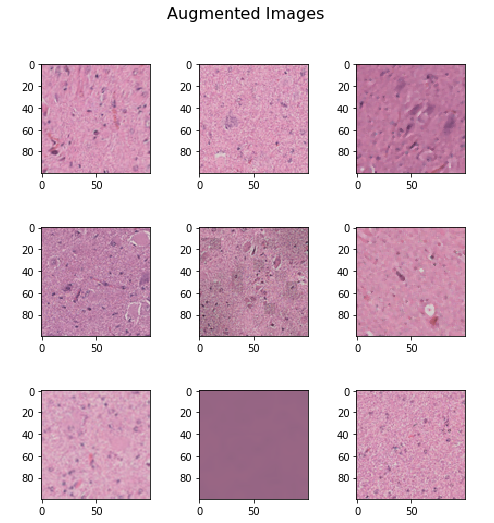

<Figure size 5000x5000 with 0 Axes>

In [7]:
looking_at_augmentation(train_gen_1, batchsize=9, path=base_path)

In [8]:
#VGG-16 for heatmap generation 
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

def get_model_classif_VGG_base_nottrainable():
    base_model_VGG = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    print('Model loaded.')
    
    for layer in base_model_VGG.layers:
        layer.trainable = False
        print("trainable:", layer.name)
    
    x = base_model_VGG.output
    x = GlobalMaxPooling2D()(x)
    x = (Dense(256, activation='relu'))(x)
    x = (Dropout(0.5)) (x)
    predictions = (Dense(2, activation='softmax'))(x)
    model_VGG = Model(inputs=base_model_VGG.input, outputs=predictions)

    adam = optimizers.Adam()
    model_VGG.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=[categorical_accuracy, auc_roc])

    model_VGG.summary()
    return model_VGG

def get_model_classif_VGG_base_trainable():
    base_model_VGG = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    print('Model loaded.')
    
    for layer in base_model_VGG.layers:
        layer.trainable = True
        print("trainable:", layer.name)
    
    x = base_model_VGG.output
    x = GlobalMaxPooling2D()(x)
    x = (Dense(256, activation='relu'))(x)
    x = (Dropout(0.4)) (x)
    predictions = (Dense(2, activation='softmax'))(x)
    model_VGG = Model(inputs=base_model_VGG.input, outputs=predictions)

    adam = optimizers.Adam()
    model_VGG.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=[categorical_accuracy, auc_roc])

    model_VGG.summary()
    return model_VGG

# Training Toplayers

In [ ]:
model_VGG = get_model_classif_VGG_base_nottrainable()
#model_VGG.load_weights('C:\Users\eg38emed\FCD\Models\VGG_dataset2_clr\VGG_dataset2_clr.h5')

In [ ]:
import sys
from keras_lr_finder import LRFinder

lr_gen = datagen_train.flow_from_directory(train_path,
                                        #target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        crop_size = (100,100),
                                        batch_size=5000,
                                        class_mode='categorical')

x_lr_train,y_lr_train= lr_gen.next()
print(x_lr_train.shape)
lr_finder = LRFinder(model_VGG)

In [ ]:
lr_finder.find(x_lr_train, y_lr_train, 0.000001, 0.1, batch_size=128, epochs=4)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)

In [ ]:
import clr_callback
def get_callbacks_clr(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=15, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    clr = clr_callback.CyclicLR(base_lr=0.0001, max_lr=0.01,
                        step_size=num_train_samples/train_batch_size_1/2)
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_toplayer.csv".format(model_name), append=True)
    return [clr, earlystopping, ReduceLR, checkpoint, csv_logger]

def get_callbacks(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=15, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_ALL.csv".format(model_name), append=True)
    return [earlystopping, ReduceLR, checkpoint, csv_logger]

name_weights = (base_path + "\\{}.h5".format(model_name))
callbacks_list = get_callbacks_clr(name_weights = name_weights)

In [ ]:
#model_VGG.load_weights(base_path + "\\{}.h5".format(model_name))
history = model_VGG.fit_generator(train_gen_1, 
                    steps_per_epoch=train_gen_1.samples // train_batch_size_1*10, 
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // val_batch_size*10,
                    epochs=13, verbose=1,
                    callbacks=callbacks_list)

plot_history(history, modelname = model_name, path=base_path)

# Training baselayers

In [9]:
#FINETUNE ALL VGG
model_VGG = get_model_classif_VGG_base_trainable()

Model loaded.
trainable: input_1
trainable: block1_conv1
trainable: block1_conv2
trainable: block1_pool
trainable: block2_conv1
trainable: block2_conv2
trainable: block2_pool
trainable: block3_conv1
trainable: block3_conv2
trainable: block3_conv3
trainable: block3_pool
trainable: block4_conv1
trainable: block4_conv2
trainable: block4_conv3
trainable: block4_pool
trainable: block5_conv1
trainable: block5_conv2
trainable: block5_conv3
trainable: block5_pool
Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block

In [10]:
from keras_lr_finder import LRFinder
lr_gen = datagen_train.flow_from_directory(train_path,
                                        #target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        crop_size = (100,100),
                                        batch_size=5000,
                                        class_mode='categorical')

x_lr_train,y_lr_train= lr_gen.next()
print(x_lr_train.shape)
lr_finder = LRFinder(model_VGG)

Found 2300 images belonging to 2 classes.
(2300, 100, 100, 3)


no list
Epoch 1/4
2300/2300 [==============================] - 8s 3ms/step - loss: 0.9963 - categorical_accuracy: 0.4983 - auc_roc: 0.4737
Epoch 2/4
2300/2300 [==============================] - 4s 2ms/step - loss: 0.7541 - categorical_accuracy: 0.5330 - auc_roc: 0.5088
Epoch 3/4
2240/2300 [============================>.] - ETA: 0s - loss: 0.9252 - categorical_accuracy: 0.5004 - auc_roc: 0.5141

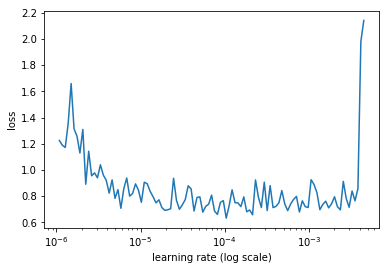

In [11]:
lr_finder.find(x_lr_train, y_lr_train, 0.000001, 0.1, batch_size=64, epochs=4)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)

In [ ]:
#clr.reset()

In [13]:
import clr_callback
def get_callbacks_clr(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=15, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    clr = clr_callback.CyclicLR(base_lr=0.000001, max_lr=0.00001,
                        step_size=num_train_samples/train_batch_size_1/2)
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_ALL.csv".format(model_name), append=True)
    return [clr, earlystopping, ReduceLR, checkpoint, csv_logger]

def get_callbacks(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=15, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_ALL.csv".format(model_name), append=True)
    return [earlystopping, ReduceLR, checkpoint, csv_logger]

name_weights = (base_path + "\\{}_100_DO0.6_ALL.h5".format(model_name))
callbacks_list = get_callbacks_clr(name_weights = name_weights)

In [ ]:
model_VGG.load_weights(base_path + "\\{}_100_ALL.h5".format(model_name))
history = model_VGG.fit_generator(train_gen_1, 
                    steps_per_epoch=train_gen_1.samples // train_batch_size_1*20, 
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // val_batch_size*20,
                    epochs=20, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/20


In [ ]:
plot_history(history, modelname = model_name, path=base_path)